# Predictive Spend Analysis - Agriculture Spending

This project focuses on analyzing supply chain data to develop a predictive model for spending. Using historical data such as sale dates, pricing, and quantities sold, we aimed to forecast spending trends while uncovering actionable insights for procurement planning.

**Key Steps:**
- Cleaned and prepared the data for accuracy and consistency.
- Enhanced data by engineering features like lagged spend values and temporal patterns to improve predictions.
- Built and evaluated a Linear Regression model to forecast spend and assess its performance.
- Highlighted strengths and challenges in the model, linking technical findings to real-world business applications.

**Business Relevance:**
This analysis enables better **budget planning** and **procurement decision-making** by identifying spending patterns and forecasting future spend based on key predictors like market price and sales trends.

**Dataset:** [Agricultural Products Sales Data 2022-2023](https://www.kaggle.com/datasets/kdstoys/agricultural-products-sales-data-2022-2023)

## Step 1: Load and Inspect Data

**We Load/Inspect the data for understanding.**


In [1]:
import pandas as pd

file_path = r"RegressionAgricultureData/AgricultureData.csv"
df = pd.read_csv(file_path)

df.head()

,product_id,product_name,category,price_per_kg,units_shipped_kg,units_sold_kg,units_on_hand_kg,supplier,farm_location,sale_date
0,b12c721e-8301-4b08-8ac3-d435be9b8b32,Lamb,Livestock,14.10,19224,14905,4319,Organic Meats Co.,"O'Reillyboro, OR",2022-07-04
1,4a0f8862-c851-4073-bc17-3a3d93834902,Beef,Livestock,11.37,29504,4550,24954,Organic Meats Co.,"Lake Nora, AR",2023-10-21
2,be996df6-1780-4352-8b7d-1f927279aa49,Oranges,Fruits,2.59,1838,1722,116,Berry Fields,"East Friedaside, NM",2023-12-24
3,6c8adfc3-2114-4b78-a3e2-2269a6a0dc02,Milk,Dairy,1.34,6750,1232,5518,Fresh Dairy Farms,"East Javon, FL",2023-12-25
4,0bd5bf2b-be0a-4ba0-aa92-059021b169e3,Bananas,Fruits,1.78,48729,47020,1709,Golden Orchards,"Lake D'angelo, MN",2023-06-20


## Step 2: Prepare the Data

**We prepare the data by calculating total spend, focusing on relevant columns, and standardizing the sale_date format.**


In [2]:
# Calculate total spend column
df['spend'] = df['price_per_kg'] * df['units_sold_kg']

# Selecting relevant columns for analysis
df = df[['sale_date', 'price_per_kg', 'units_sold_kg', 'spend']]

# Convert sale_date to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])

df.head()

,sale_date,price_per_kg,units_sold_kg,spend
0,2022-07-04,14.10,14905,210160.50
1,2023-10-21,11.37,4550,51733.50
2,2023-12-24,2.59,1722,4459.98
3,2023-12-25,1.34,1232,1650.88
4,2023-06-20,1.78,47020,83695.60


## Step 3: Check for Missing Values

**We checked for missing values across all columns, displayed affected rows, and counted missing values per column to identify data quality issues.**


In [3]:
# Check for missing values across all columns
missing_data = df.isna()

# Display the rows that contain any missing values
rows_with_missing = df[missing_data.any(axis=1)]
print(rows_with_missing)

# Count the total number of missing values in each column
missing_count = df.isna().sum()
print("Number of missing values in each column:")
print(missing_count)



Empty DataFrame
Columns: [sale_date, price_per_kg, units_sold_kg, spend]
Index: []
Number of missing values in each column:
sale_date        0
price_per_kg     0
units_sold_kg    0
spend            0
dtype: int64


## Step 4: Analyze Spending Trends

**We aggregated total spend by date and visualized spending trends over time using a line plot, helping identify patterns or fluctuations in spending behavior.**


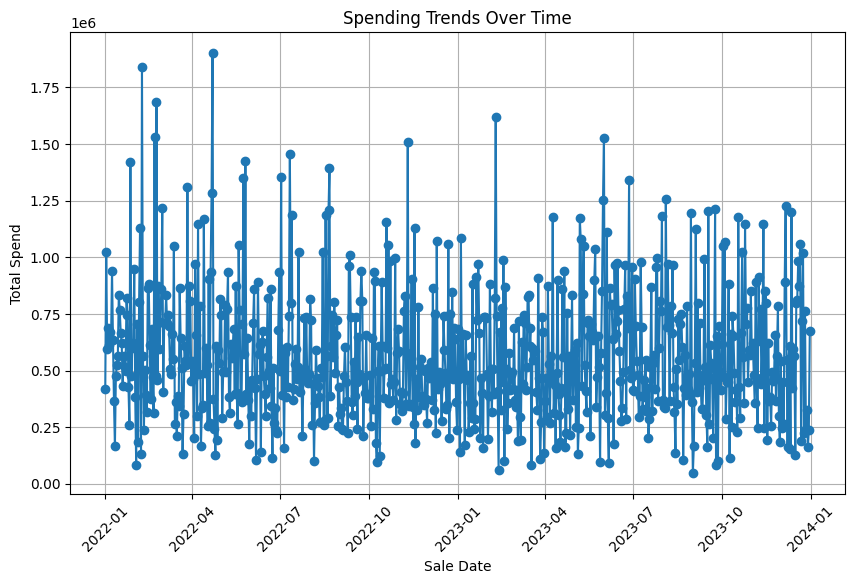

In [4]:
import matplotlib.pyplot as plt

# Aggregate spend by date
spend_trends = df.groupby('sale_date')['spend'].sum().reset_index()

# Plot spend trends over time
plt.figure(figsize=(10, 6))
plt.plot(spend_trends['sale_date'], spend_trends['spend'], marker='o')
plt.title("Spending Trends Over Time")
plt.xlabel("Sale Date")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Step 5: Data Enhancement

**We enhanced the dataset by:**
- Extracting time-based features (`year`, `month`, `day_of_week`) from the `sale_date` column to capture temporal patterns.
- Creating a lag feature (`lag_spend`) to incorporate historical spend data as a predictor for future spending.
- Removing rows with NaN values introduced by the lag feature to maintain data integrity.


In [5]:
# Data enhancements by generating additional columns
df['year'] = df['sale_date'].dt.year
df['month'] = df['sale_date'].dt.month
df['day_of_week'] = df['sale_date'].dt.dayofweek  # Monday = 0, Sunday = 6

# Create lag feature for spend (1 period prior)
df['lag_spend'] = df['spend'].shift(1)

# Drop rows with NaN values created by lag
df.dropna(inplace=True)

df.head()

,sale_date,price_per_kg,units_sold_kg,spend,year,month,day_of_week,lag_spend
1,2023-10-21,11.37,4550,51733.50,2023,10,5,210160.50
2,2023-12-24,2.59,1722,4459.98,2023,12,6,51733.50
3,2023-12-25,1.34,1232,1650.88,2023,12,0,4459.98
4,2023-06-20,1.78,47020,83695.60,2023,6,1,1650.88
5,2023-01-22,0.92,11477,10558.84,2023,1,6,83695.60


## Step 6: Build and Evaluate the Regression Model

**We built and evaluated a Linear Regression model by:**
- Selecting key predictors (`price_per_kg`, `units_sold_kg`, `year`, `month`, `day_of_week`, and `lag_spend`) as features and `spend` as the target variable.
- Splitting the dataset into training and testing sets to ensure robust evaluation.
- Training the Linear Regression model on the training data to predict future spending.
- Evaluating the model's performance using **Mean Squared Error (MSE)** to measure average prediction errors and **R-squared** to assess how well the model explains variance in spend.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target
X = df[['price_per_kg', 'units_sold_kg', 'year', 'month', 'day_of_week', 'lag_spend']]
y = df['spend']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Predictor Coefficients:", (model.coef_))  # To view coefficients for each predictor
print("Y Intercept:", (model.intercept_))  # To view the intercept
print()

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Predictor Coefficients: [ 1.28543293e+04  3.72564049e+00  1.45528706e+03  7.05766162e+01
 -2.16360197e+02  4.56586677e-03]
Y Intercept: -2990356.5887962272

Mean Squared Error: 1475044277.4029887
R-squared: 0.7252659120742853


## Step 7: Visualize Predicted vs Actual Values

**We plotted predicted versus actual spend values using a scatter plot to assess the model's prediction quality and visualize discrepancies:**
- Each point represents a prediction compared to the corresponding actual value.
- A red dashed line indicates perfect predictions, making it easy to evaluate the model's accuracy.
- The visualization highlights areas where the model performs well and where discrepancies occur, particularly for higher spend values.


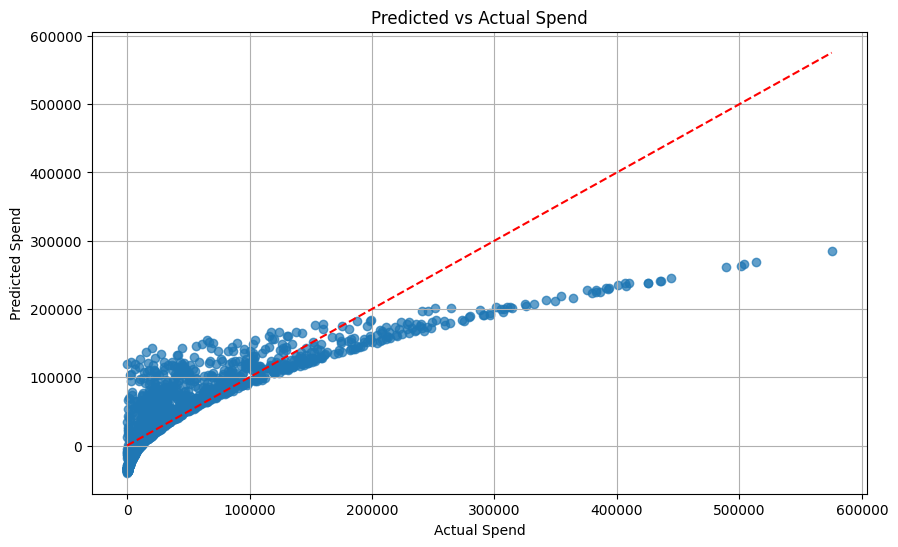

In [7]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Spend")
plt.xlabel("Actual Spend")
plt.ylabel("Predicted Spend")
plt.grid(True)
plt.show()


# Findings and Insights

## Predictive Strengths
- The model performed well for smaller spend values (≤ 200,000), with predictions closely aligning to actual amounts.
- Temporal trends and pricing relationships were effectively captured, contributing to the model's accuracy.

## Predictive Challenges
- For higher spend values (> 200,000), predictions showed variability and often underestimated actual spend.

## Evaluation and Business Relevance
- **R-squared (0.72):** Explained 72% of the variance in spend, demonstrating the model's reliability for forecasting.
- **Mean Squared Error (MSE):** Highlighted variability in predictions, particularly for larger spend values.
- **Practical Application:** The model enables better budgeting and procurement planning by forecasting future spending based on key predictors.
